<a href="https://colab.research.google.com/github/nhv3/Master-Control-230/blob/master/Master_Notebook_CNN_V2_CS230_R11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
##VERSION 
# Removed TF1
# Removed ignite metrics, focusing on visualization for now
# Using resnet18, not pretrained
# Decreased batch size, image size, and epoch #
# Added normalization in data_transforms to match normalization in imshow (without matching plotted images look bad) - may need to adjust these parameters later

# To add to AWS notebook: dataloader/imshow normalization matching, imshow & visualize_model functions

In [2]:
# Click on the URL link it gives you to mount the drive 
##NEW change comment to test git push
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
cd /content/drive/My Drive/CS230 Project/Data

/content/drive/My Drive/CS230 Project/Data


In [0]:
#Import the right libraries 
import pandas as pd 
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pathlib
from distutils.dir_util import copy_tree
import os
import random
import shutil
import array as arr 
import torchvision
from torchvision import datasets, models, transforms

In [5]:
# Declare all the COVID image paths
trainCOVID_dir = "/content/drive/My Drive/CS230 Project/Data/train_images/COVID"
valCOVID_dir = "/content/drive/My Drive/CS230 Project/Data/val_images/COVID"
testCOVID_dir = "/content/drive/My Drive/CS230 Project/Data/test_images/COVID"

trainNONCOVID_dir = "/content/drive/My Drive/CS230 Project/Data/train_images/NON_COVID"
valNONCOVID_dir = "/content/drive/My Drive/CS230 Project/Data/val_images/NON_COVID"
testNONCOVID_dir = "/content/drive/My Drive/CS230 Project/Data/test_images/NON_COVID"

# Declare paths
covid_dir = "/content/drive/My Drive/CS230 Project/Data/COVID"
noncovid_dir ="/content/drive/My Drive/CS230 Project/Data/Non-COVID"
train_dir = "/content/drive/My Drive/CS230 Project/Data/Sets/Training"
sets_dir = "/content/drive/My Drive/CS230 Project/Data/Sets/"
train_dir_cov = "/content/drive/My Drive/CS230 Project/Data/Sets/Training/COVID"
train_dir_ncov = "/content/drive/My Drive/CS230 Project/Data/Sets/Training/Non-COVID"
dev_dir = "/content/drive/My Drive/CS230 Project/Data/Sets/Dev"
dev_dir_cov = "/content/drive/My Drive/CS230 Project/Data/Sets/Dev/COVID"
dev_dir_ncov = "/content/drive/My Drive/CS230 Project/Data/Sets/Dev/Non-COVID"
test_dir = "/content/drive/My Drive/CS230 Project/Data/Sets/Test"
test_dir_cov = "/content/drive/My Drive/CS230 Project/Data/Sets/Test/COVID"
test_dir_ncov = "/content/drive/My Drive/CS230 Project/Data/Sets/Test/Non-COVID"

#Image path for new data imported from ActualMed Repo 
covid_amed_dir = '/content/drive/My Drive/CS230 Project/Data/New Data/covid';
ncovid_amed_dir = '/content/drive/My Drive/CS230 Project/Data/New Data/ncovid'; 

print('Checking Volumes :::: ')
train_cov_numr = len(os.listdir(train_dir_cov))
dev_cov_numr = len(os.listdir(dev_dir_cov))
test_cov_numr = len(os.listdir(test_dir_cov))
train_ncov_numr = len(os.listdir(train_dir_ncov))
dev_ncov_numr = len(os.listdir(dev_dir_ncov))
test_ncov_numr = len(os.listdir(test_dir_ncov))

train_cov_nume = 170
dev_cov_nume = 65
test_cov_nume = 65
train_ncov_nume = 871
dev_ncov_nume = 65
test_ncov_nume = 65

estimated = [train_cov_nume, dev_cov_nume,  test_cov_nume,  train_ncov_nume, dev_ncov_nume, test_ncov_nume]
retrieved = [train_cov_numr, dev_cov_numr,  test_cov_numr,  train_ncov_numr, dev_ncov_numr, test_ncov_numr]
same = (estimated == retrieved) 

if(same): 
  print('Sets are imported as expected')
  blockrun = True

else: 
  print('Sets are not the same - look at the configuations printed below')

#Check if Train/Dev/Test Sets are Populated
print('Total images in training covid set: ' + str(train_cov_numr) + ':::::: Expected ::::: ' + str(train_cov_nume)) #expected: 
print('Total images in training noncovid set: ' + str(train_ncov_numr) + ':::::: Expected ::::: ' + str(train_ncov_nume)) #expected: 
print('Total images in dev covid set: ' + str(dev_cov_numr) + ':::::: Expected ::::: ' + str(dev_cov_nume)) #expected:
print('Total images in dev noncovid set: ' +  str(dev_ncov_numr) + ':::::: Expected ::::: ' + str(dev_ncov_nume)) #expected: 
print('Total images in test covid set: ' +  str(test_cov_numr) + ':::::: Expected ::::: ' + str(test_cov_nume)) #expected: 
print('Total images in test noncovid set: ' + str(test_ncov_numr) + ':::::: Expected ::::: ' + str(test_ncov_nume)) #expected: 


Checking Volumes :::: 
Sets are imported as expected
Total images in training covid set: 170:::::: Expected ::::: 170
Total images in training noncovid set: 871:::::: Expected ::::: 871
Total images in dev covid set: 65:::::: Expected ::::: 65
Total images in dev noncovid set: 65:::::: Expected ::::: 65
Total images in test covid set: 65:::::: Expected ::::: 65
Total images in test noncovid set: 65:::::: Expected ::::: 65


In [0]:
# Only Run if Train/Dev/Test Unpopulated
# Pools all COVID/NonCOVID Images

#os.makedirs(covid_dir)
#os.makedirs(noncovid_dir)
#os.makedirs(train_dir_cov) 
#os.makedirs(train_dir_ncov)
#os.makedirs(dev_dir_cov)
#os.makedirs(dev_dir_ncov)
#os.makedirs(test_dir_cov)
#os.makedirs(test_dir_ncov)

if (not same):
  covid_path = pathlib.Path('/content/drive/My Drive/CS230 Project/Data/COVID')
  noncovid_path = pathlib.Path('/content/drive/My Drive/CS230 Project/Data/Non-COVID')

  #Move all the COVID and Non-COVID Images into their own folders (done once)
  copy_tree(trainCOVID_dir, covid_dir)
  copy_tree(valCOVID_dir, covid_dir)
  copy_tree(testCOVID_dir, covid_dir)
  copy_tree(covid_amed_dir, covid_dir)

  copy_tree(trainNONCOVID_dir, noncovid_dir)
  copy_tree(valNONCOVID_dir, noncovid_dir)
  copy_tree(testNONCOVID_dir, noncovid_dir)
  copy_tree(ncovid_amed_dir, noncovid_dir)

  #Count up data
  image_count_covid = len(os.listdir(covid_dir))
  image_count_noncovid = len(os.listdir(noncovid_dir))
  print("Total images in COVID set: " + str(image_count_covid))
  print("Total images in Non-COVID set: " + str(image_count_noncovid))

  total_images = image_count_covid+image_count_noncovid
  print("Total images: " + str(total_images))

else: 
  #Count up data
  print('Folders are already populated, no need to reload sets. If sets have been loaded, COVID and Non-Covid drives will show 0 since the files were moved')
  image_count_covid = len(os.listdir(covid_dir))
  image_count_noncovid = len(os.listdir(noncovid_dir))
  print("Total images in COVID set: " + str(image_count_covid))
  print("Total images in Non-COVID set: " + str(image_count_noncovid))

  total_images = image_count_covid+image_count_noncovid
  print("Total images: " + str(total_images))


Folders are already populated, no need to reload sets. If sets have been loaded, COVID and Non-Covid drives will show 0 since the files were moved
Total images in COVID set: 0
Total images in Non-COVID set: 0
Total images: 0


In [0]:
# Only Run if Train/Dev/Test Unpopulated
# Move the data to Training, Dev, and Test sets (80-10-10)
numdevtest = total_images//10

if(not same):
  # Define dev/test covid:non-covid ratio

  for ii in range(numdevtest//2):
    image = random.choice(os.listdir(covid_dir))
    os.rename((covid_dir+"/"+image), (test_dir_cov+"/"+image))

  for ii in range(numdevtest//2):
    image = random.choice(os.listdir(noncovid_dir))
    os.rename((noncovid_dir+"/"+image), (test_dir_ncov+"/Non-"+image))

  image_count_covid = len(os.listdir(covid_dir))
  image_count_noncovid = len(os.listdir(noncovid_dir))
  print("After populating test set...")
  print("Total images in COVID set: " + str(image_count_covid))
  print("Total images in Non-COVID set: " + str(image_count_noncovid))

else: 
  print('Set already populated')


Set already populated


In [0]:
# Only Run if Train/Dev/Test Unpopulated
#Populate dev set
if(not same):
  for ii in range(numdevtest//2):
    image = random.choice(os.listdir(covid_dir))
    os.rename((covid_dir+"/"+image), (dev_dir_cov+"/"+image))

  for ii in range(numdevtest//2):
    image = random.choice(os.listdir(noncovid_dir))
    os.rename((noncovid_dir+"/"+image), (dev_dir_ncov+"/"+image))

  image_count_covid = len(os.listdir(covid_dir))
  image_count_noncovid = len(os.listdir(noncovid_dir))
  print("After populating dev set...")
  print("Total images in COVID set: " + str(image_count_covid))
  print("Total images in Non-COVID set: " + str(image_count_noncovid))

else: 
  print('Set already populated')


Set already populated


In [0]:
# Only Run if Train/Dev/Test Unpopulated
# Populate train set 
if(not same):
  for ii in range(image_count_covid):
    image = random.choice(os.listdir(covid_dir))
    os.rename((covid_dir+"/"+image), (train_dir_cov+"/"+image))

  for ii in range(image_count_noncovid):
    image = random.choice(os.listdir(noncovid_dir))
    os.rename((noncovid_dir+"/"+image), (train_dir_ncov+"/"+image))

  image_count_covid = len(os.listdir(covid_dir))
  image_count_noncovid = len(os.listdir(noncovid_dir))
  print("After populating training set...")
  print("Total images in COVID set: " + str(image_count_covid))
  print("Total images in Non-COVID set: " + str(image_count_noncovid))

else: 
  print('Set already populated')


Set already populated


In [6]:
import torch
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets, models

#CLASS_NAMES = np.array([item.name for item in train_dir if item.name != '.ipynb_checkpoints'])
CLASS_NAMES = np.array(os.listdir(train_dir))


# %tensorflow_version 1.x
import tensorflow as tf
# The 1./255 is to convert from uint8 to float32 in range [0,1].
#image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)



image_count_train = len(os.listdir(train_dir_cov))+len(os.listdir(train_dir_ncov))
image_count_dev = len(os.listdir(dev_dir_cov))+len(os.listdir(dev_dir_ncov))
image_count_test = len(os.listdir(test_dir_cov))+len(os.listdir(test_dir_ncov))
##Getting images just for train for now. Will get the other in later. But use the train first to test some type of model to see baseline errors 
BATCH_SIZE = 16
IMG_HEIGHT = 200
IMG_WIDTH = 200
STEPS_PER_EPOCH_train = np.ceil(image_count_train/BATCH_SIZE)
STEPS_PER_EPOCH_test = np.ceil(image_count_test/BATCH_SIZE)
STEPS_PER_EPOCH_val = np.ceil(image_count_dev/BATCH_SIZE)

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transforms.ToTensor(), 
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transforms.ToTensor(), 
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transforms.ToTensor(), 
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}
directories = {'train':'Training', 'val':'Dev', 'test': 'Test'}
image_datasets = {x: datasets.ImageFolder(os.path.join(sets_dir, directories[x]),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Class Names: " + str(class_names))



Class Names: ['COVID', 'Non-COVID']


In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

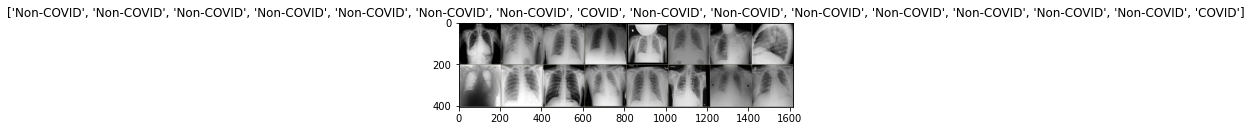

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]) + '\n actual: {}'.format(class_names[labels[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [0]:
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

model_ft = models.resnet18(pretrained=False)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [11]:
import time
import copy
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=2)

Epoch 0/1
----------
train Loss: 1.2826 Acc: 0.7867
val Loss: 0.9700 Acc: 0.5000

Epoch 1/1
----------
train Loss: 0.4137 Acc: 0.8367
val Loss: 0.9483 Acc: 0.5000

Training complete in 3m 25s
Best val Acc: 0.500000


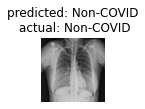

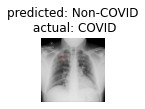

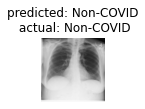

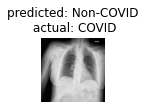

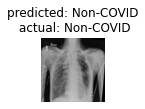

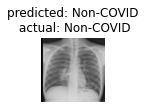

In [12]:
visualize_model(model_ft)